## Daniel Burke Etivity3 Classification
12067717

Task One - Classification

Requirements:

- For each classifier, include data preparation and dimensionality reduction steps in the main pipeline.

- You can choose any classifier as the third one. Some options are MLPClassifier, Naive Bayes, and kNN, but you are not limited to them.
- For the dimensionality reduction step use PCA, RFE and a third dimensionality reduction (incl. feature selection) technique in at least one pipeline.
- Use grid search for hyperparameter tuning and replicate the process in the example notebook Tutorial 3-1 - Binary Classification.ipynb to evaluate and compare the models you have trained and pick the best one.

- Summarise your experience in a markdown cell (max 150 words in a markdown cell).

In [1]:
#A. Import Python Modules and Dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, RobustScaler, FunctionTransformer, OneHotEncoder

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.compose import ColumnTransformer

from sklearn import svm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_recall_fscore_support, classification_report
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

from sklearn.naive_bayes import GaussianNB

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

from sklearn import set_config
current_palette = sns.color_palette('pastel')

In [2]:
# https://www.kaggle.com/datasets/mirichoi0218/insurance 

#B. Load the dataset
df = pd.read_csv("./insurance.csv")
df_original = df.copy() # make a copy

# first inspection of the data
print('      Dataset      ')
print('------------------------')
print(f'Number of samples   : {df.shape[0]}')
print(f'Number of attributes: {df.shape[1]}')
print()

      Dataset      
------------------------
Number of samples   : 1338
Number of attributes: 7



#### Columns / Features

age: age of primary beneficiary

sex: insurance contractor gender, female, male

bmi: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height,
objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9

children: Number of children covered by health insurance / Number of dependents

smoker: Smoking

region: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.

charges: Individual medical costs billed by health insurance

### EDA - Exploratory Data Analysis

In [3]:
# replace insurance_cost with insurance binary as instructed
df['insurance_cost_binary'] = (df['insurance_cost'] > df['insurance_cost'].median()).astype(int)
df.drop(columns=['insurance_cost'], inplace=True)

In [4]:
# discretize the age column values into bins of decades.
bins = [10, 20, 30, 40, 50, 60, 70]
labels = ['10-20', '20-30', '30-40', '40-50', '50-60', '60-70']
df['age_bin'] = pd.cut(df['age'], bins=bins, labels=False, right=False) # create new feature to replace old one

# Adjust the labels for ages 18 and 19 to include them in the '20-30' bin
df.loc[df['age'].between(18, 19), 'age_bin'] = labels.index('20-30') # use index to create ordinal data
df.drop(columns=['age'], inplace=True)

FEATURES = list(df.columns.values)
print(FEATURES)

CATEGORICAL_FEATURES = df.select_dtypes(include=['object']).columns.tolist()
print(CATEGORICAL_FEATURES)

NUMERICAL_FEATURES = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
print(NUMERICAL_FEATURES)

df.info()

['gender', 'bmi', 'children', 'smoker', 'region', 'insurance_cost_binary', 'age_bin']
['gender', 'smoker', 'region']
['bmi', 'children', 'insurance_cost_binary', 'age_bin']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   gender                 1338 non-null   object 
 1   bmi                    1338 non-null   float64
 2   children               1338 non-null   int64  
 3   smoker                 1338 non-null   object 
 4   region                 1338 non-null   object 
 5   insurance_cost_binary  1338 non-null   int64  
 6   age_bin                1338 non-null   int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 73.3+ KB


In [5]:
df.describe().T

count       mean       std    min       25%   50%  \
bmi                    1338.0  30.663397  6.098187  15.96  26.29625  30.4   
children               1338.0   1.094918  1.205493   0.00   0.00000   1.0   
insurance_cost_binary  1338.0   0.500000  0.500187   0.00   0.00000   0.5   
age_bin                1338.0   2.557549  1.337025   1.00   1.00000   2.0   

                            75%    max  
bmi                    34.69375  53.13  
children                2.00000   5.00  
insurance_cost_binary   1.00000   1.00  
age_bin                 4.00000   5.00

In [6]:
df.describe(include=['object']) #describing the categorical varibles

gender smoker     region
count    1338   1338       1338
unique      2      2          4
top      male     no  southeast
freq      676   1064        364

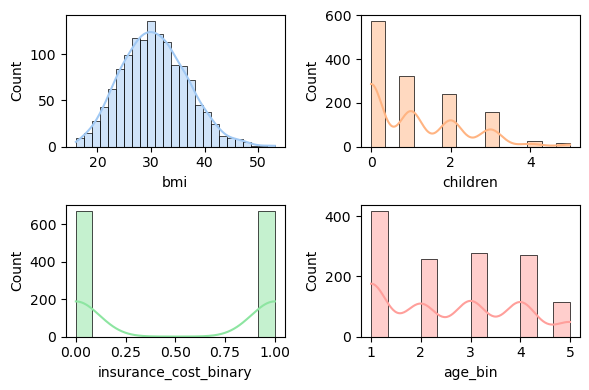

Skewness  Kurtosis
bmi                    0.284047 -0.050732
children               0.938380  0.202454
insurance_cost_binary  0.000000 -2.002996
age_bin                0.275278 -1.191760

In [7]:
# a quick look at the numerical features
plt.figure(figsize=(6, 4))
for i, FEATURE in enumerate(NUMERICAL_FEATURES, 1):
    plt.subplot(2, 2, i)
    sns.histplot(df[FEATURE], kde=True, stat="count", linewidth=0.5, color=current_palette[i-1])
    plt.tight_layout()

plt.show()
skewness = df.skew(numeric_only=True)
kurtosis = df.kurtosis(numeric_only=True)
pd.DataFrame({'Skewness': skewness, 'Kurtosis': kurtosis})

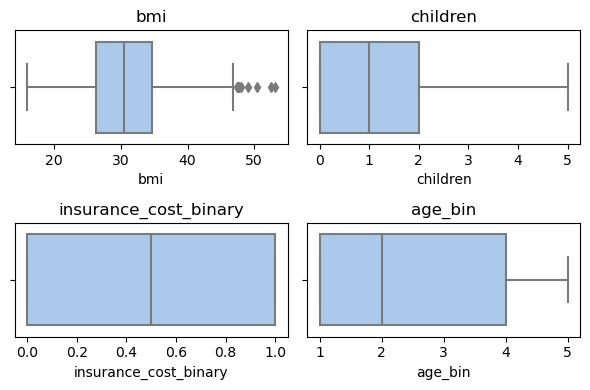

In [8]:
# a boxplot look at the numerical features
plt.figure(figsize=(6, 4))
for i, FEATURE in enumerate(NUMERICAL_FEATURES, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x=df[FEATURE], palette=current_palette)
    plt.title(FEATURE)
    plt.tight_layout()

plt.show()

There are now four numerical features:

- The BMI feature is evenly spread, with it almost being a normal distribution, but wild a mild skew to the right.

- The children column is quite right skewed, with a skewness value of almost one, it is very obvious I will need to deal with it.

- The insurance cost had a large number of outliers, and was very right skewed, but after the transformation with a binary value representing above and below the median, it is very well behaved. There is nothing else needed in terms of transformations.

- After discretizing the age column into bins representing each decade of age it is now much better proportioned and has a fairly low skew. I added the teenager ages 18 and 19 to the 20-30 bin, which then resulted in some slight skew to the right.

Note: I suspect that the outliers in insurance cost were corresponding to those with the largest age, and those who smoke, but they won't cost problems in the data any more.


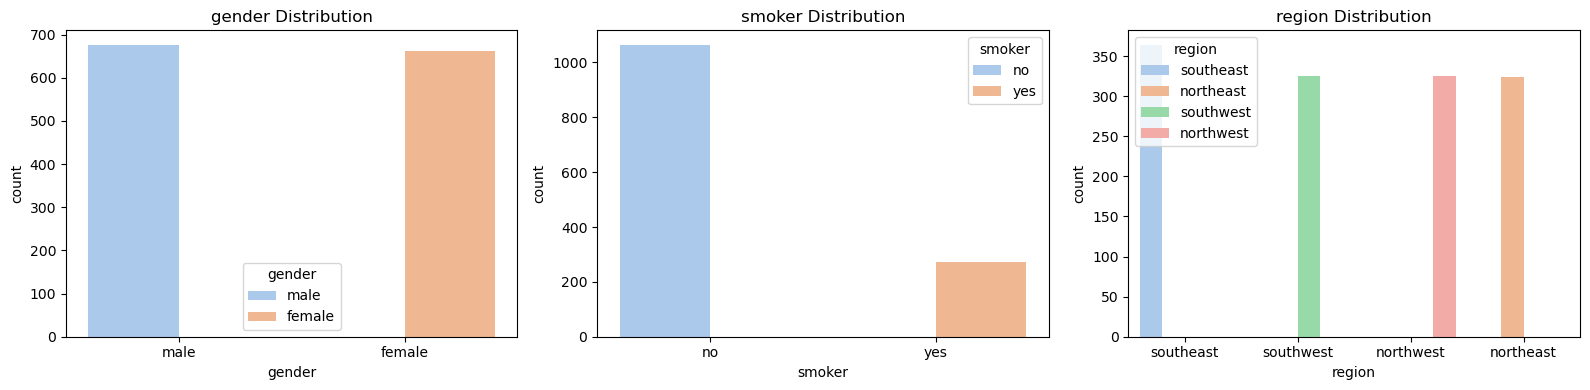

In [9]:
# a quick look at the categorical features
fig, axs = plt.subplots(1, len(CATEGORICAL_FEATURES), figsize=(16, 4))

for i, FEATURE in enumerate(CATEGORICAL_FEATURES):

    sns.countplot(x=FEATURE, data=df, ax=axs[i], order=df[FEATURE].value_counts().index, hue=df[FEATURE], palette=current_palette)
    axs[i].set_title(f'{FEATURE} Distribution')

plt.tight_layout()
plt.show()

Two of these categorical features, Gender and Region appear well balanced, whereas the smoker distribution does not.

The region column is a candidate for me for Feature Selection, I am going to drop it, as when I ran the code the first time, it did not appear to have any significant effects in the accuracy for the model, so presented itself to me to be dropped. In addition, I am going to include dimensionality reduction in each pipeline.

In [10]:
# categorical features as a dataframe & total number of null values.
value_counts_df = pd.DataFrame(columns=['Feature', 'Value', 'Count'])
data = []

for feature in CATEGORICAL_FEATURES:
    counts = df[feature].value_counts()
    
    for value, count in counts.items():
        
        data.append({'Feature': feature, 'Value': value, 'Count': count})

value_counts_df = pd.DataFrame(data)

print(value_counts_df.to_string(index=False))
df.isnull().sum()

Feature     Value  Count
 gender      male    676
 gender    female    662
 smoker        no   1064
 smoker       yes    274
 region southeast    364
 region southwest    325
 region northwest    325
 region northeast    324


gender                   0
bmi                      0
children                 0
smoker                   0
region                   0
insurance_cost_binary    0
age_bin                  0
dtype: int64

There are no missing or null values, so I will not have to impute for those. I will replace the two binaries before I set up the pipeline in the next section.

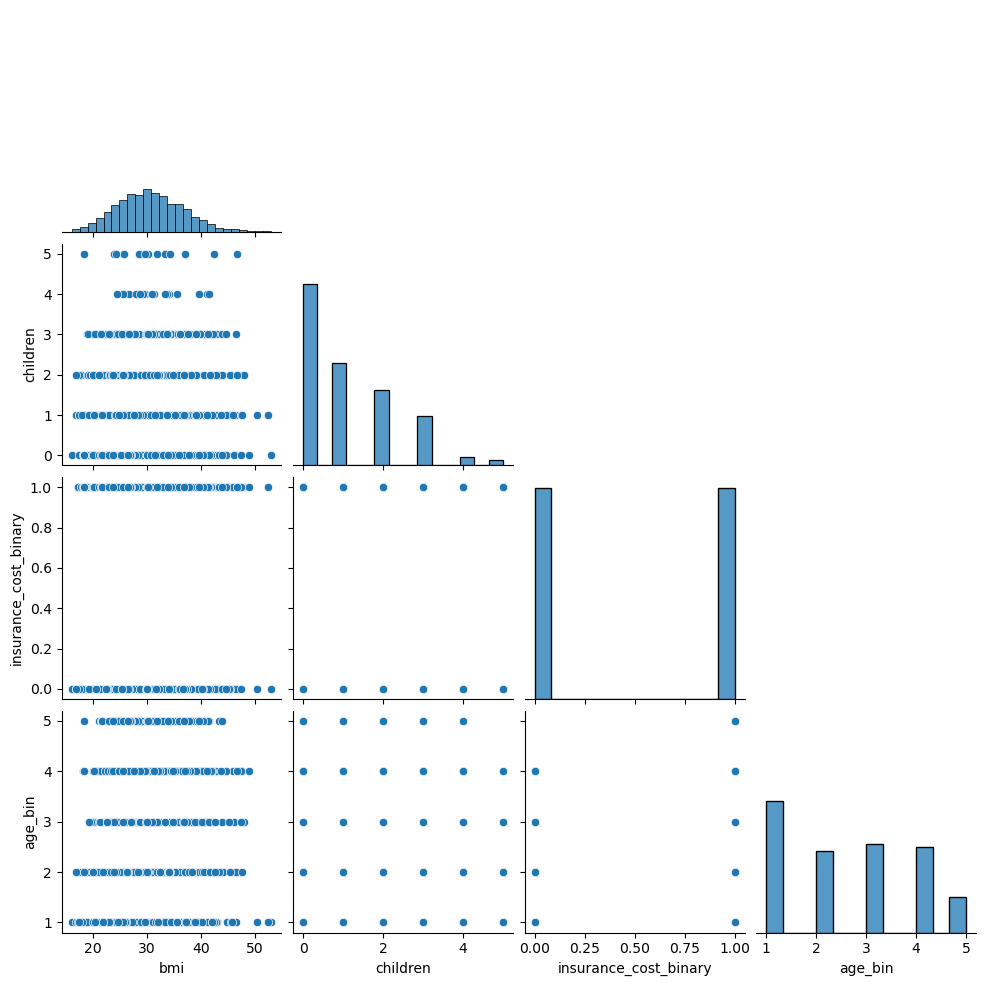

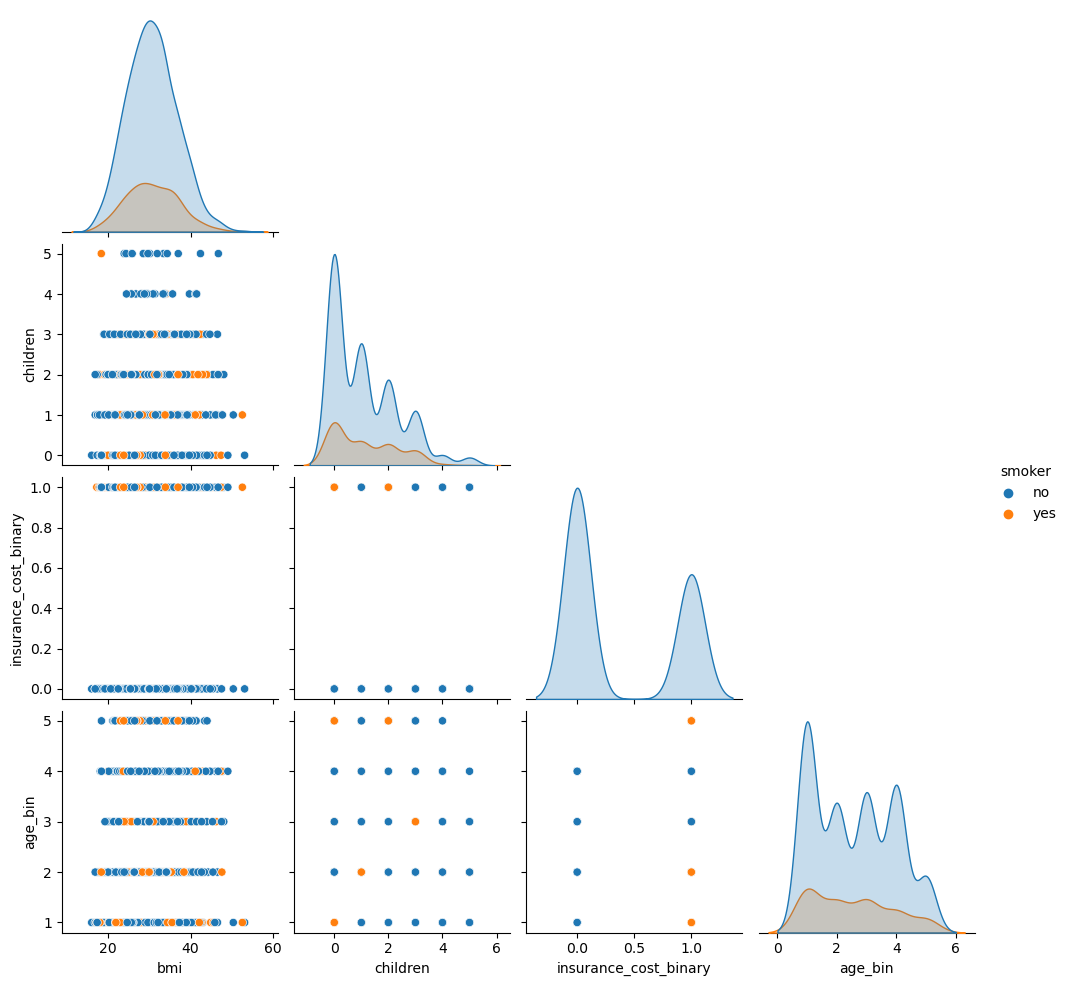

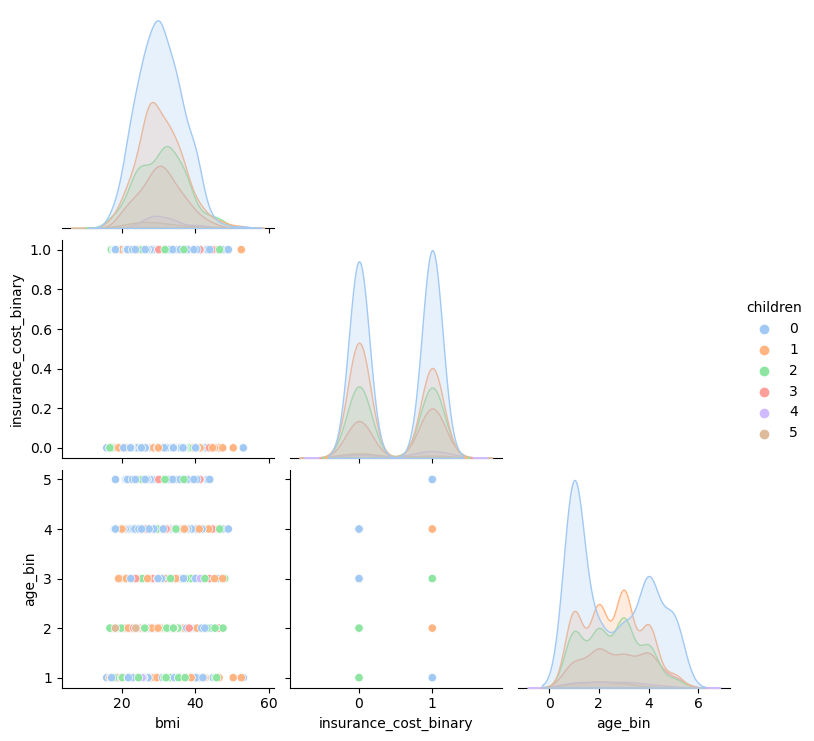

In [11]:
# plot the numeric columns but split by smoking - most interesting features along with #children
sns.pairplot(data=df, corner=True)
sns.pairplot(data=df, corner=True, hue="smoker")
sns.pairplot(data=df, corner=True, hue="children", palette=current_palette)
plt.show()

It appears that every smoker is in the higher insurance cost binary value from the pairplots. This is intuitively true but I want to examine a bit more to make sure I haven't made a mistake.

In [12]:
cross_tab_check = pd.crosstab(df['smoker'], df['insurance_cost_binary'])
print(cross_tab_check)

insurance_cost_binary    0    1
smoker                         
no                     669  395
yes                      0  274


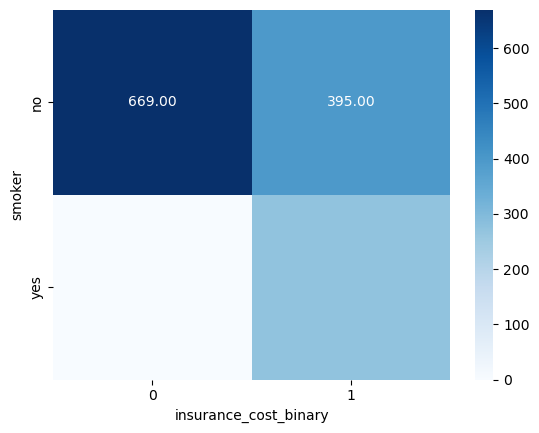

In [13]:
sns.heatmap(cross_tab_check, annot=True, fmt='.2f', cmap='Blues')
plt.show()

### Data preparation and encoding


| Feature | Total Count | Missing Count | Skew | Outliers | Encoding | Rescaling | Transform |
|:---|:---|---|---|:---|:---|:---|:---|
|gender|1338|0| | | binary |  | |
|bmi|1338|0| mild right| | | RobustScaler | log |
|children|1338|0| right| yes | | MinMaxScaler| cube root |
|smoker|1338|0| | | binary | | |
|region|1338|0| | | One-Hot | | |
|insurance_cost|1338|0| strong right| yes | target variable | | |
|age|1338|0| | | Discretized & Dropped | | |
| **new features** | | |  |  | | | |
| age_bin |1338|0| mild right |  | |  | |



##### Numerical Features
* Due to the presence of a number of outliers in the numerical feature BMI, I am going to scale with RobustScaler. Robust scaler scales using the median and the Interquartile range, instead of the standard deviation / mean, which means it's a good choice in the presence of outliers. I am going to use a log transformer as I feel its best suited to tackle the distribution of values.

* I am going to use a cube transformer to transform the children feature due to its large skewness value of almost one, and because there are quite a few examples of people with zero children.

* I am not going to change the insurance_cost column any further.

* The age feature has already been discretized and I am not going to change it any further.

Note: I am going to do all the work not already done at this stage, in the pipeline.

##### Categorical Features
* I am going to One-hot Encode the region feature. I am going to do this in the pipeline. For some of the classifiers I have considered and am going to drop this feature (or set of features) as mentioned above.

* I am going to binary encode the gender and smoking features. I am going to do this below before the pipeline.

##### Dimensionality Reduction / Feature Selectiom
Note: I had initially considered dropping the bmi feature for feature selection, but due to the small number of features in the dataset, and due to me getting good scores from the classifiers the first time around, It is too important a feature to drop.



In [14]:
'''another two binaries'''

smoker_dict = {'yes': 1, 'no': 0}
df['smoker'] = df['smoker'].replace(smoker_dict)
gender_dict = {'male': 1, 'female': 0}
df['gender'] = df['gender'].replace(gender_dict)

#df['smoker'].value_counts()
#df['gender'].value_counts()

In [15]:
df.describe().T

count       mean       std    min       25%   50%  \
gender                 1338.0   0.505232  0.500160   0.00   0.00000   1.0   
bmi                    1338.0  30.663397  6.098187  15.96  26.29625  30.4   
children               1338.0   1.094918  1.205493   0.00   0.00000   1.0   
smoker                 1338.0   0.204783  0.403694   0.00   0.00000   0.0   
insurance_cost_binary  1338.0   0.500000  0.500187   0.00   0.00000   0.5   
age_bin                1338.0   2.557549  1.337025   1.00   1.00000   2.0   

                            75%    max  
gender                  1.00000   1.00  
bmi                    34.69375  53.13  
children                2.00000   5.00  
smoker                  0.00000   1.00  
insurance_cost_binary   1.00000   1.00  
age_bin                 4.00000   5.00

Next I am going to split the columns into a target *`y`* and predictors *`X`*.

In [16]:
y = df['insurance_cost_binary']
X = df.drop('insurance_cost_binary', axis=1)

In [17]:
y.info() # target
X.info() # predictors

<class 'pandas.core.series.Series'>
RangeIndex: 1338 entries, 0 to 1337
Series name: insurance_cost_binary
Non-Null Count  Dtype
--------------  -----
1338 non-null   int64
dtypes: int64(1)
memory usage: 10.6 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   gender    1338 non-null   int64  
 1   bmi       1338 non-null   float64
 2   children  1338 non-null   int64  
 3   smoker    1338 non-null   int64  
 4   region    1338 non-null   object 
 5   age_bin   1338 non-null   int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 62.8+ KB


### Pipeline

In [18]:
# Prepare the pipeline for preprocessing

# group 1
columns_skewed = ['children']

# group 2
columns_outliers = ['bmi']

# group 3
CATEGORICAL_FEATURES = df.select_dtypes(include=['object']).columns.tolist() # just the regions left

# group 3: all other predictors
columns_no_outliers = [item for item in list(df.columns) 
                             if item not in columns_outliers and item not in columns_skewed
                             and item not in CATEGORICAL_FEATURES]

# verify the correct columns are selected
print(columns_no_outliers)
print(len(columns_no_outliers))



['gender', 'smoker', 'insurance_cost_binary', 'age_bin']
4


In [19]:
# build the preprocessing pipeline using pipeline and columntransformer


# children column has high skew but no outliers
skewed_pipeline = Pipeline(
    steps = [
        ("cubic_root_transform", FunctionTransformer(np.cbrt, feature_names_out='one-to-one')),                          
        ("scaler", MinMaxScaler())                                                             
    ]
)

# bmi column has outliers and also has mild skew
outliers_pipeline = Pipeline(
    steps = [
        ("log_transform", FunctionTransformer(np.log, feature_names_out='one-to-one')),
        ("scaler", RobustScaler())
    ]
)

# I may drop these features in the various below pipelines.
cat_pipeline = Pipeline(
    steps = [
        ("onehot", OneHotEncoder(handle_unknown='ignore')),
        #("scaler", RobustScaler())
    ]
)


## SVM Pipeline
'''all of these are the same for now as I have not done any dimensional reduction'''
preprocess_pipeline_svm = ColumnTransformer(
    transformers = [
        ("skewed", skewed_pipeline, columns_skewed),    
        ("outliers", outliers_pipeline, columns_outliers),
        ("onehot", cat_pipeline, CATEGORICAL_FEATURES)                                            # consider drop the categoricals
    ],
    remainder="passthrough"                                                                       # above three columns passed through
)

## RF Pipeline
preprocess_pipeline_rf = ColumnTransformer(
    transformers = [
        ("skewed", skewed_pipeline, columns_skewed),    
        ("outliers", outliers_pipeline, columns_outliers),
        ("onehot", cat_pipeline, CATEGORICAL_FEATURES)    
        #("onehot", 'drop', CATEGORICAL_FEATURES)                                                  
    ],
    remainder="passthrough"                                                                       # above three columns passed through
)

## NB Pipeline
preprocess_pipeline_nb = ColumnTransformer(
    transformers = [
        ("skewed", skewed_pipeline, columns_skewed),    
        ("outliers", outliers_pipeline, columns_outliers),
        ("onehot", 'drop', CATEGORICAL_FEATURES)                                                  # drop the categoricals
    ],
    remainder="passthrough"                                                                       # above three columns passed through
)

In [20]:
# split into training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)

#stratify ensures the two classes are represented in the same proportion in the training and test sets.

In [21]:
preprocess_pipeline_svm

ColumnTransformer(remainder='passthrough',
                  transformers=[('skewed',
                                 Pipeline(steps=[('cubic_root_transform',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<ufunc 'cbrt'>)),
                                                 ('scaler', MinMaxScaler())]),
                                 ['children']),
                                ('outliers',
                                 Pipeline(steps=[('log_transform',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<ufunc 'log'>)),
                                                 ('scaler', RobustScaler())]),
                                 ['bmi']),
                                ('onehot',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['region'])])

In [22]:
# examine the preprocess_pipelines

transformed_df_svm = pd.DataFrame(preprocess_pipeline_svm.fit_transform(X), columns=preprocess_pipeline_svm.get_feature_names_out())
transformed_df_svm.info()

# 9 features to work with if nothing is dropped

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   skewed__children          1338 non-null   float64
 1   outliers__bmi             1338 non-null   float64
 2   onehot__region_northeast  1338 non-null   float64
 3   onehot__region_northwest  1338 non-null   float64
 4   onehot__region_southeast  1338 non-null   float64
 5   onehot__region_southwest  1338 non-null   float64
 6   remainder__gender         1338 non-null   float64
 7   remainder__smoker         1338 non-null   float64
 8   remainder__age_bin        1338 non-null   float64
dtypes: float64(9)
memory usage: 94.2 KB


In [23]:
transformed_df_nb = pd.DataFrame(preprocess_pipeline_nb.fit_transform(X), columns=preprocess_pipeline_nb.get_feature_names_out())
transformed_df_nb

# 5 features if regions are dropped

skewed__children  outliers__bmi  remainder__gender  remainder__smoker  \
0             0.584804       0.379349                1.0                0.0   
1             0.000000       0.414439                1.0                0.0   
2             0.000000      -0.520701                0.0                0.0   
3             0.736806       0.867785                0.0                0.0   
4             0.000000       0.572306                0.0                0.0   
...                ...            ...                ...                ...   
1333          0.736806       0.165298                0.0                0.0   
1334          0.000000      -0.443376                0.0                1.0   
1335          0.000000      -0.507698                1.0                0.0   
1336          0.736806       0.705053                1.0                1.0   
1337          0.000000      -0.889244                1.0                1.0   

      remainder__age_bin  
0                    1.0  
1                    1.0  
2                    1.0  
3                    1.0  
4                    1.0  
...                  ...  
1333                 5.0  
1334                 5.0  
1335                 5.0  
1336                 5.0  
1337                 5.0  

[1338 rows x 5 columns]

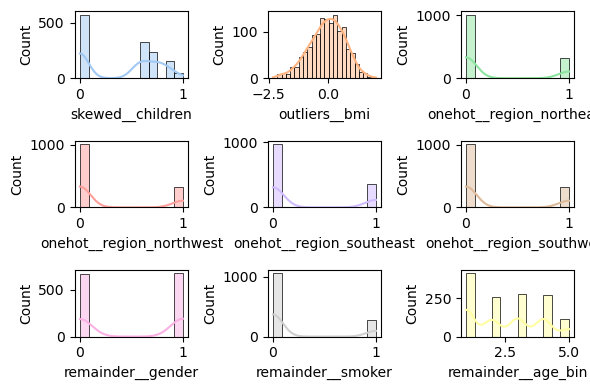

Skewness  Kurtosis
skewed__children         -0.097116 -1.745179
outliers__bmi            -0.256655 -0.134286
onehot__region_northeast  1.205161 -0.548410
onehot__region_northwest  1.200409 -0.559857
onehot__region_southeast  1.025621 -0.949523
onehot__region_southwest  1.200409 -0.559857
remainder__gender        -0.020951 -2.002557
remainder__smoker         1.464766  0.145756
remainder__age_bin        0.275278 -1.191760

In [24]:
'''plot the boxplots and histplots for the numerical features'''
NUMERICAL_FEATURES_TRANSFORMED = transformed_df_svm.select_dtypes(include=['int64', 'float64']).columns.to_list()
plt.figure(figsize=(6, 4))
for i, FEATURE in enumerate(NUMERICAL_FEATURES_TRANSFORMED, 1):
    plt.subplot(3, 3, i)
    sns.histplot(transformed_df_svm[FEATURE], kde=True, stat="count", linewidth=0.5, color=current_palette[i-1])
    plt.tight_layout()

plt.show()
skewness = transformed_df_svm.skew(numeric_only=True)
kurtosis = transformed_df_svm.kurtosis(numeric_only=True)
pd.DataFrame({'Skewness': skewness, 'Kurtosis': kurtosis})

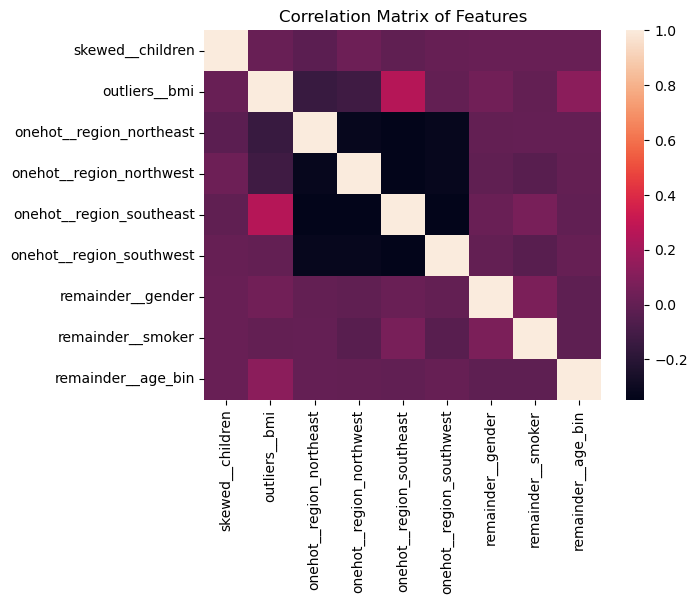

In [25]:
correlation_matrix = transformed_df_svm.corr()
sns.heatmap(correlation_matrix, cbar=True)
plt.title('Correlation Matrix of Features')
plt.show()

In [27]:
transformed_df_svm['target'] = y

target                      1.000000
remainder__age_bin          0.520056
remainder__smoker           0.507463
outliers__bmi               0.091351
onehot__region_northeast    0.055829
remainder__gender          -0.002990
skewed__children           -0.006441
onehot__region_southeast   -0.006718
onehot__region_northwest   -0.019171
onehot__region_southwest   -0.029628
Name: target, dtype: float64


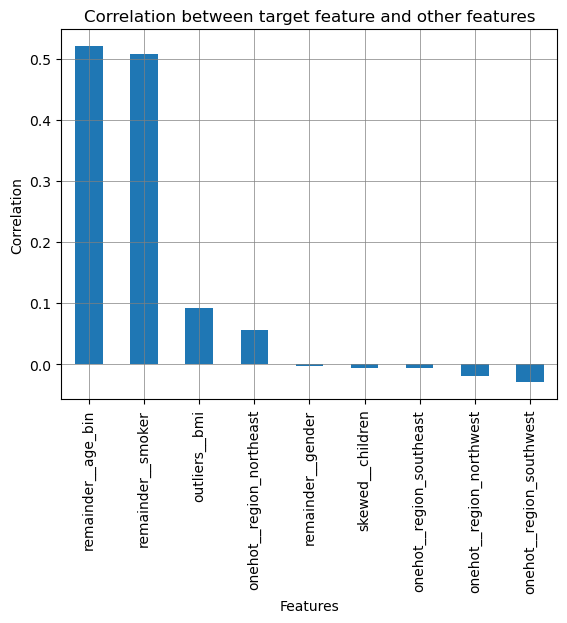

In [28]:
print(transformed_df_svm.corr()['target'].sort_values(ascending=False))

# continuing looking at the correlations
transformed_df_svm.corr()['target'].sort_values(ascending=False).drop('target').plot(kind='bar')

plt.title('Correlation between target feature and other features')
plt.ylabel('Correlation')
plt.xlabel('Features')
plt.grid(True, which='both', axis='both', linestyle='-', linewidth=0.5, color='gray')
plt.show()

I can see from the correlation matrix that the negative correlation scores around the regions are going to interfere with the models accuracy. I am thinking about dropping the features altogether, but due to the small number of features already, I will keep it in for the first two models and see if the dimensionality reduction analysis recommends that I use less features first.

Also, something I speculated on can now be seen clearly, the age and the smoking binary are by far the most important feature in the dataset.

## Model Training

### SVM
Support Vector Machine

In [29]:
# create the pipeline
pipe = Pipeline(steps=[
    ('preprocess', preprocess_pipeline_svm), 
    ('reduce_dim', 'passthrough'),
    #('pca', PCA()),                                # passthrough for now
    ('svm', svm.SVC(probability=True))
])

set_config(display="diagram")
pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('skewed',
                                                  Pipeline(steps=[('cubic_root_transform',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<ufunc 'cbrt'>)),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['children']),
                                                 ('outliers',
                                                  Pipeline(steps=[('log_transform',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<ufunc 'log'>)),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['bmi']),
                                                 ('onehot',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['region'])])),
                ('reduce_dim', 'passthrough'), ('svm', SVC(probability=True))])

In [30]:
# prepare a parameter grid for SVM

N_FEATURES_OPTIONS = [1,2,3,4,5,6,7,8,9] # full range of features

param_grid = [
        {
        'reduce_dim': [PCA(iterated_power='auto')],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'svm__C': [0.01, 0.1, 1, 10, 100],  
        'svm__gamma': [1, 0.1, 0.01, 0.001], 
        'svm__kernel': ['rbf', 'linear', 'poly']
        }

        #{
        #'reduce_dim': [RFE(estimator=RandomForestClassifier())],
        #'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        #'svm__C': [0.01, 0.1, 1, 10, 100],  
        #'svm__gamma': [1, 0.1, 0.01, 0.001], 
        #'svm__kernel': ['rbf', 'linear', 'poly']
        #}
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)                    # 5 fold cross validation
search.fit(X_train, y_train)                                                            #training happens here! SVM is trained for 3m 58sec

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
SVM_best_params = search.best_params_
SVM_best_model = search.best_estimator_



Best CV score = 0.921:
Best parameters:  {'reduce_dim': PCA(n_components=7), 'reduce_dim__n_components': 7, 'svm__C': 0.01, 'svm__gamma': 1, 'svm__kernel': 'poly'}


Dimensionality Reduction: PCA dimensionality reduction has recommended to drop two features, and to keep seven features. I had initially ran this with a larger set of hyperparameters, but it was taking too long to run the grid search. These appear to be both regions in the dataset.

### Random Forest
Random Forest Classifier

In [31]:
# repeat the pipeline for RF
from sklearn.feature_selection import SelectFromModel

pipe = Pipeline(steps=[
    ('preprocess', preprocess_pipeline_rf), 
    ('reduce_dim', 'passthrough'),
    #('feature_selection', SelectFromModel(svm.LinearSVC(dual="auto", penalty="l1"))), # dealt with below
    ('rf', RandomForestClassifier())
    ]
)

set_config(display="diagram")
pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('skewed',
                                                  Pipeline(steps=[('cubic_root_transform',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<ufunc 'cbrt'>)),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['children']),
                                                 ('outliers',
                                                  Pipeline(steps=[('log_transform',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<ufunc 'log'>)),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['bmi']),
                                                 ('onehot',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['region'])])),
                ('reduce_dim', 'passthrough'),
                ('rf', RandomForestClassifier())])

In [32]:
# prepare a parameter grid for RandomForest
# note also that this is not an exhaustive list of the parameters of RandomForestClassifier and their possible values

N_FEATURES_OPTIONS = [6,7,8,9] # just look at upper range of features

param_grid = [
    {
    'reduce_dim': [PCA(iterated_power='auto')],
    'reduce_dim__n_components': N_FEATURES_OPTIONS,
    'rf__n_estimators' : [10,20,30,40,50,60],
    'rf__max_depth': [2, 4, 6, 8, 10]
    },
    {
    'reduce_dim': [RFE(estimator=RandomForestClassifier())],
    'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
    'rf__n_estimators': [10,20,30,40,50,60],
    'rf__max_depth': [2, 4, 6, 8, 10]
    },
    #{
    #'reduce_dim': [SelectFromModel(svm.LinearSVC(dual="auto", penalty="l1"))],
    #'rf__n_estimators': [10,20,30,40,50,60],
    #'rf__max_depth': [2, 4, 6, 8, 10]
    #},
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)    # 5 fold cross-validation
search.fit(X_train, y_train)                                            # time taken 2mins for 0.92 score
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

Best CV score = 0.922:
Best parameters:  {'reduce_dim': RFE(estimator=RandomForestClassifier(), n_features_to_select=6), 'reduce_dim__n_features_to_select': 6, 'rf__max_depth': 6, 'rf__n_estimators': 30}


Here I have done a grid search for hyperparameters, and in addition added in dimensionality reduction using PCA and RFE. Note that it says the number of features to select is 6, so it is dropping three features, these must be the three regions which are the lest correlated in the above plots with the target feature. Overall the results are good and I am happy with the performance of this technique.

### Naive Bayes
Third Classifier - Naive Bayes.

Naive Bayes classifiers are one of the simplest Bayesian Network models. They are a family of linear probabilistic classifiers, which all are based around the assumption that a particular feature is independent of the value of any other variable. This may not be the most accurate model in this case, as some of the features such as age and number of children may be closely related to each other.

In [33]:
# repeat the pipeline for nb

pipe = Pipeline(steps=[
    ('preprocess', preprocess_pipeline_nb),  # this time one-hot encoded categoricals are all dropped.
    ('reduce_dim', 'passthrough'),
    ('nb', GaussianNB())
])

set_config(display="diagram")
pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('skewed',
                                                  Pipeline(steps=[('cubic_root_transform',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<ufunc 'cbrt'>)),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['children']),
                                                 ('outliers',
                                                  Pipeline(steps=[('log_transform',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<ufunc 'log'>)),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['bmi']),
                                                 ('onehot', 'drop',
                                                  ['region'])])),
                ('reduce_dim', 'passthrough'), ('nb', GaussianNB())])

In [34]:
# prepare a parameter grid for NaiveBayes
N_FEATURES_OPTIONS = [1,2,3,4,5] # reduced set range of features

# Naive Bayes accepts no HyperParameters. Just include dimensionality reduction and the already included feature selection
param_grid_nb = [
    {
    'reduce_dim': [PCA(iterated_power='auto')],
    'reduce_dim__n_components': N_FEATURES_OPTIONS,
    },
    {
    'reduce_dim': [RFE(estimator=RandomForestClassifier())],
    'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
    },
]


# Perform grid search for Naive Bayes
search_nb = GridSearchCV(pipe, param_grid_nb, n_jobs=-1, cv=10, refit=True)      # 10 fold cross-validation
search_nb.fit(X_train, y_train)

# Print best CV score and best parameters for Naive Bayes
print("Best CV score = %0.3f:" % search_nb.best_score_)
print("Best parameters: ", search_nb.best_params_)

# Store the best params and best model for later use
NB_best_params = search_nb.best_params_
NB_best_model = search_nb.best_estimator_
y_pred = search_nb.predict(X_test)


print(confusion_matrix(y_test, y_pred), ": is the confusion matrix")
print(accuracy_score(y_test, y_pred), ": is the accuracy score")
print(precision_score(y_test, y_pred), ": is the precision score")
print(recall_score(y_test, y_pred), ": is the recall score")
print(f1_score(y_test, y_pred), ": is the f1 score")

Best CV score = 0.910:
Best parameters:  {'reduce_dim': PCA(n_components=4), 'reduce_dim__n_components': 4}
[[132   2]
 [ 28 106]] : is the confusion matrix
0.8880597014925373 : is the accuracy score
0.9814814814814815 : is the precision score
0.7910447761194029 : is the recall score
0.8760330578512396 : is the f1 score


* historical best results
Best CV score = 0.707:
Best parameters:  {}
[[134   0]
 [ 82  52]] : is the confusion matrix
0.6940298507462687 : is the accuracy score
1.0 : is the precision score
0.3880597014925373 : is the recall score
0.5591397849462366 : is the f1 score

* historical note: I think the low scores are coming here because the columns are not fully independent of each other, which is what NB needs to get accurate results. I do not have hyperparameters here to tune, but I can play with dimensionality reduction/feature selection

I had originally got very low scores in the range of 0.7. PCA recommended a reduced featureset of 4/5 columns, which I used the pipeline in order to reduce. I dropped the region column, which resulted in four final features in the dataset being dropped, due to the one-hot encoding used in the previous two pipelines. 

When I ran the gridsearch this time, it has increased it's accuracy alot due to the reduced featureset, PCA is actually now recommending 4 features only. 

## Compare Classification Models on Test Set

The evaluation function below evaluates a model on a test data set. 

The preprocessing pipeline is applied to the test set in all examples. These results I will then use to rank the classifiers and decide which one will train the final model.

- accuracy
- precisions
- recall
- F1-score
- TPR (true positive rate)
- AUC (area under the ROC curve)

To plot ROC curves for the models, we need to ensure that the same false positive rate (fpr) scale is used for all curves. For this reason, we take a scale of 100 equally spaced fpr values between 0 and 1 and interpolate the true positive rate (tpr) for them.

In [35]:
mean_fpr = np.linspace(start=0, stop=1, num=100)

# model - a trained binary probabilistic classification model; # straight from tutorial
#         it is assumed that there are two classes: 0 and 1
#         and the model predicts probabilities for the examples to belong to class 1

def evaluate_model(X_test, y_test, model):
    # compute probabilistic predictiond for the evaluation set
    _probabilities = model.predict_proba(X_test)[:, 1]
    
    # compute exact predictiond for the evaluation set
    _predicted_values = model.predict(X_test)
        
    # compute accuracy
    _accuracy = accuracy_score(y_test, _predicted_values)
        
    # compute precision, recall and f1 score for class 1
    _precision, _recall, _f1_score, _ = precision_recall_fscore_support(y_test, _predicted_values, labels=[1])
    
    # compute fpr and tpr values for various thresholds 
    # by comparing the true target values to the predicted probabilities for class 1
    _fpr, _tpr, _ = roc_curve(y_test, _probabilities)
        
    # compute true positive rates for the values in the array mean_fpr
    _tpr_transformed = np.array([np.interp(mean_fpr, _fpr, _tpr)])
    
    # compute the area under the curve
    _auc = auc(_fpr, _tpr)
            
    return _accuracy, _precision[0], _recall[0], _f1_score[0], _tpr_transformed, _auc

In [36]:
# using the above function to train the three models used above

SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score, SVM_tpr, SVM_auc = evaluate_model(X_test, y_test, SVM_best_model)
RF_accuracy, RF_precision, RF_recall, RF_f1_score, RF_tpr, RF_auc = evaluate_model(X_test, y_test, RF_best_model)
nb_accuracy, nb_precision, nb_recall, nb_f1_score, nb_tpr, nb_auc = evaluate_model(X_test, y_test, NB_best_model)

In [37]:
SVM_metrics = np.array([SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score])
RF_metrics = np.array([RF_accuracy, RF_precision, RF_recall, RF_f1_score])
nb_metrics = np.array([nb_accuracy, nb_precision, nb_recall, nb_f1_score])
index = ['accuracy', 'precision', 'recall', 'F1-score']
df_metrics = pd.DataFrame({'SVM': SVM_metrics, 'Random Forest': RF_metrics, 'Naive Bayes': nb_metrics}, index=index)
ax = df_metrics.plot(kind='bar', rot=0, color=current_palette)
ax.legend(loc='upper right', bbox_to_anchor=(1.25, 1))
plt.show()

In [38]:
print('SVM Report')
print(classification_report(y_test, SVM_best_model.predict(X_test)))
print('RandomForest Report')
print(classification_report(y_test, RF_best_model.predict(X_test)))
print('NaiveBayes Report')
print(classification_report(y_test, NB_best_model.predict(X_test)))

SVM Report
              precision    recall  f1-score   support

           0       0.85      0.96      0.90       134
           1       0.96      0.83      0.89       134

    accuracy                           0.90       268
   macro avg       0.90      0.90      0.90       268
weighted avg       0.90      0.90      0.90       268

RandomForest Report
              precision    recall  f1-score   support

           0       0.85      0.98      0.91       134
           1       0.97      0.82      0.89       134

    accuracy                           0.90       268
   macro avg       0.91      0.90      0.90       268
weighted avg       0.91      0.90      0.90       268

NaiveBayes Report
              precision    recall  f1-score   support

           0       0.82      0.99      0.90       134
           1       0.98      0.79      0.88       134

    accuracy                           0.89       268
   macro avg       0.90      0.89      0.89       268
weighted avg       0.90  

Previously it was very easy to see the poor performance of the NB classifier compared to the other two models. After reducing the features in the model it is giving much better performance, on par with if not marginally better than the other two models.

I would pick the SVM as the best performing model at the minute, it is performing however marginally better than the Naive bayes and the Random Forest model in recall and virtually identical to the other two in three of the remaining categories.

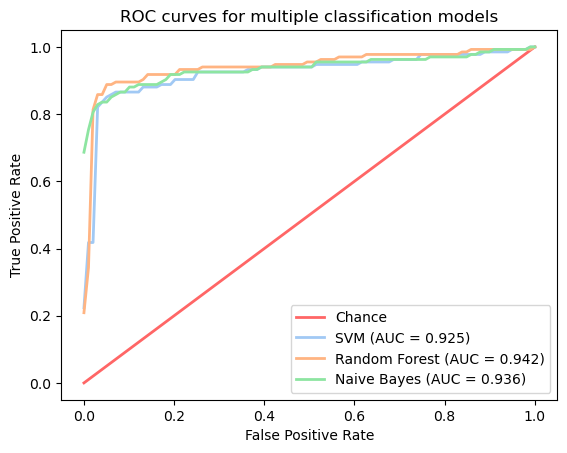

In [39]:
plt.plot([0, 1], [0, 1], linestyle='-', lw=2, color='r', label='Chance', alpha=0.6)
plt.plot(mean_fpr, SVM_tpr[0,:], lw=2, color=current_palette[0], label='SVM (AUC = %0.3f)' % (SVM_auc), alpha=1.0)
plt.plot(mean_fpr, RF_tpr[0,:], lw=2, color=current_palette[1], label='Random Forest (AUC = %0.3f)' % (RF_auc), alpha=1.0)
plt.plot(mean_fpr, nb_tpr[0,:], lw=2, color=current_palette[2], label='Naive Bayes (AUC = %0.3f)' % (nb_auc), alpha=1.0)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for multiple classification models')
plt.legend(loc="lower right")
plt.show()

This is a good result as it shows that all three predictors are performing much better than a guess result.

## Train the Final Model

I have decided based on the results of the above results to choose the SVM as the best performing and final model.

In [40]:
# slice the SVM_best_params
#SVM_best_params = SVM_best_params[2:]

def transform(dict):
    '''function will remove the string svm from the names of the parameters in SVM_best_params but ignore reduction params'''
    return {key.replace('svm__', ''): value for key, value in dict.items() if not str(value).startswith('red')}

#final_pipeline = make_pipeline(preprocess_pipeline_svm, svm.SVC(**transform(SVM_best_params)))

final_model = SVM_best_model.fit(X, y)
final_model

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('skewed',
                                                  Pipeline(steps=[('cubic_root_transform',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<ufunc 'cbrt'>)),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['children']),
                                                 ('outliers',
                                                  Pipeline(steps=[('log_transform',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<ufunc 'log'>)),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['bmi']),
                                                 ('onehot',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['region'])])),
                ('reduce_dim', PCA(n_components=7)),
                ('svm', SVC(C=0.01, gamma=1, kernel='poly', probability=True))])

In [41]:
# if needed later
import pickle
filename = 'final_model.sav'
pickle.dump(final_model, open(filename, 'wb'))

## Question: Summarise your experience (max 150 words).

I have used three different classifiers with the insurance dataset (SVM, RF, NB) and performed some analysis to compare the results from the three of these, and pick one (SVM) as the best performing model.

The first two models, SVM and Random Forest perform the best, with very accurate results obtained, and a number of hyperparameters explored through GridSearch for both models. These did not take long to find the best results, maybe minutes, allowing me to experiment with correlation to consider feature selection, and tweaking the grid search hyperparameter search range.

I then used Naive Bayes in order to compare it's results with the other two, and although initially it did not perform as well at all, after removing the REGION feature, (which had been one hot encoded into four features which were dependent on each other), the accuracy proved much better, and comparibly to the other two. As there were no hyperparameters to explore, I used PCA and RFE dimensionality reduction in the grid search, as well as feature selection, just dropping the columns altogether, which proved fruitful.

I would deem all techniques successful, with high scores in every category. One thing which I could consider further if I had more time, would be re examining the age discretization and it's scaling, and the transformations, to see if I could achieve better results.
